# Pipeline Testing

In [1]:
#
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt

#
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
import datetime
import pytz
from zipline.data.bundles import load
from trading_calendars import get_calendar
import pyfolio as pf
#
%load_ext zipline

## Check Symbols of Bundle

In [5]:
now = Timestamp.utcnow()
bundle = load('NFTU', os.environ, now)
symbols = set(str(asset.symbol) 
              for asset in bundle.asset_finder.retrieve_all(
                           bundle.asset_finder.equities_sids))

print(symbols)

{'AVAX', 'SOL', 'MATIC', 'ADA', 'TFUEL', 'MANA', 'FLOW'}


## Simple Strategy

In [3]:
selected_coin = 'ADA'
shortest_period = 7
longest_period = 14
holding_period = 2

def initialize(context):
    context.i = 0
    context.holding_days = 0
    context.bought = False
    set_benchmark(symbol(selected_coin))
    context.asset = symbol(selected_coin)

def handle_data(context, data):
    # skip days for moving average
    context.i += 1
    if context.i < longest_period:
        return
    if context.bought:
        context.holding_days += 1
        
    # trading algorithm
    short_ma = data.history(context.asset, 'close', bar_count=shortest_period, frequency='1d').mean()
    long_ma = data.history(context.asset, 'close', bar_count=longest_period, frequency='1d').mean()

    open_orders = get_open_orders()
    
    # buy signal
    if context.asset not in open_orders:
        if short_ma > long_ma and context.holding_days == 0 and not context.bought:
            order_target_percent(context.asset, 1.0)
            context.bought = True
        
    # sell signal
    if (short_ma < long_ma or context.holding_days == holding_period) and context.bought:
        order_target_percent(context.asset, 0.0)
        context.holding_days = 0
        context.bought = False

    # record price
    record(close=data.current(symbol(selected_coin), 'close'),
          short_ma=short_ma,
          long_ma=long_ma)

In [4]:
# date range MUST BE pd.Timestamp
start_date = pd.Timestamp('2017-11-09', tz='utc')
end_date = pd.Timestamp('2022-04-11', tz='utc')

# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=40000,
                            handle_data=handle_data,
                            bundle='NFTU',
                            data_frequency='daily')
perf.head()
perf.tail()

C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:710: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\Michael\anaconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,period_open,period_close,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,...,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,algorithm_period_return,close,short_ma,long_ma
2022-04-07 23:59:00+00:00,2022-04-07 00:00:00+00:00,2022-04-07 23:59:00+00:00,0.0,0.0,0.0,521.92199,521.92199,521.92199,0,0,...,0.0,1611,2022-04,0.970328,42.68,1.252343,-0.986952,1.092,1.148000,1.154286
2022-04-08 23:59:00+00:00,2022-04-08 00:00:00+00:00,2022-04-08 23:59:00+00:00,0.0,0.0,0.0,521.92199,521.92199,521.92199,0,0,...,0.0,1612,2022-04,0.970027,40.04,1.252222,-0.986952,1.026,1.128143,1.149143
2022-04-09 23:59:00+00:00,2022-04-09 00:00:00+00:00,2022-04-09 23:59:00+00:00,0.0,0.0,0.0,521.92199,521.92199,521.92199,0,0,...,0.0,1613,2022-04,0.969726,40.80,1.251845,-0.986952,1.045,1.112286,1.141571
2022-04-10 23:59:00+00:00,2022-04-10 00:00:00+00:00,2022-04-10 23:59:00+00:00,0.0,0.0,0.0,521.92199,521.92199,521.92199,0,0,...,0.0,1614,2022-04,0.969425,40.24,1.251478,-0.986952,1.031,1.090143,1.130786
2022-04-11 23:59:00+00:00,2022-04-11 00:00:00+00:00,2022-04-11 23:59:00+00:00,0.0,0.0,0.0,521.92199,521.92199,521.92199,0,0,...,0.0,1615,2022-04,0.969125,36.36,1.251701,-0.986952,0.934,1.050286,1.113929


In [ ]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2021-01-27')

## Simulation of Sentiment Data

One of the NFT signals we will be looking at first is sentiment data from messages about NFTs and/or the specific chains of the coins of our universe. We can start simply by assuming that text data will be assigned a 0 if it has negative sentiment, and a 1 if it has positive sentiment. Then, for trading purposes we will simulate the overall sentiment of each day with a 0 or 1.

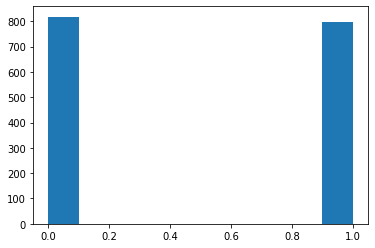

In [6]:
simulated_sentiment_arr = np.random.randint(0, 2, (end_date - start_date).days+1)
_ = plt.hist(simulated_sentiment_arr)

In [7]:
selected_coin = 'ADA'
holding_period = 2

def initialize(context):
    context.i = 0
    context.holding_days = 0
    context.bought = False
    set_benchmark(symbol(selected_coin))
    context.asset = symbol(selected_coin)

def handle_data(context, data):
    if context.bought:
        context.holding_days += 1
        
    # trading algorithm

    open_orders = get_open_orders()
    
    # buy signal
    if context.asset not in open_orders:
        if simulated_sentiment_arr[context.i] and context.holding_days == 0 and not context.bought:
            order_target_percent(context.asset, 1.0)
            context.bought = True
        
    # sell signal
    if (not simulated_sentiment_arr[context.i] or context.holding_days == holding_period) and context.bought:
        order_target_percent(context.asset, 0.0)
        context.holding_days = 0
        context.bought = False
        
    context.i += 1
    # record price
    record(close=data.current(symbol(selected_coin), 'close'))

In [8]:
# date range MUST BE pd.Timestamp
start_date = pd.Timestamp('2017-11-09', tz='utc')
end_date = pd.Timestamp('2022-04-11', tz='utc')

# performance of algorithm once run
perf = zipline.run_algorithm(start=start_date,
                            end=end_date,
                            trading_calendar=get_calendar('24/7'),
                            initialize=initialize,
                            capital_base=40000,
                            handle_data=handle_data,
                            bundle='NFTU',
                            data_frequency='daily')
perf.head()
perf.tail()

,period_open,period_close,long_value,short_value,long_exposure,pnl,short_exposure,capital_used,orders,returns,...,alpha,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label
2022-04-07 23:59:00+00:00,2022-04-07 00:00:00+00:00,2022-04-07 23:59:00+00:00,3.276,0.0,3.276,-0.004638,0.0,-3.280638,"[{'id': '7cc301a228d74ce195e25e8591d1955e', 'd...",-0.001350,...,-0.807892,0.359933,-1.560058,-2.451615,-0.999985,1.659663,0.0,0.0,1611,2022-04
2022-04-08 23:59:00+00:00,2022-04-08 00:00:00+00:00,2022-04-08 23:59:00+00:00,0.000,0.0,0.000,-0.202539,0.0,3.073461,"[{'id': '2899a70a830d486d8662b00a86b8e09b', 'd...",-0.059040,...,-0.808868,0.360134,-1.571046,-2.467012,-0.999985,1.659663,0.0,0.0,1612,2022-04
2022-04-09 23:59:00+00:00,2022-04-09 00:00:00+00:00,2022-04-09 23:59:00+00:00,3.135,0.0,3.135,-0.004568,0.0,-3.139567,"[{'id': '92ed4024ebc1402ea73aab24c4819cae', 'd...",-0.001415,...,-0.808914,0.360132,-1.570847,-2.466700,-0.999985,1.659663,0.0,0.0,1613,2022-04
2022-04-10 23:59:00+00:00,2022-04-10 00:00:00+00:00,2022-04-10 23:59:00+00:00,0.000,0.0,0.000,-0.046547,0.0,3.088454,"[{'id': '47688b7639d648b59e231a35aa5e0280', 'd...",-0.014440,...,-0.809007,0.360138,-1.573296,-2.470405,-0.999985,1.659663,0.0,0.0,1614,2022-04
2022-04-11 23:59:00+00:00,2022-04-11 00:00:00+00:00,2022-04-11 23:59:00+00:00,0.000,0.0,0.000,0.000000,0.0,0.000000,[],0.000000,...,-0.807695,0.359739,-1.572804,-2.469641,-0.999985,1.659663,0.0,0.0,1615,2022-04


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.00,2018-01-03,2020-11-20,NaT,NaN
1,30.63,2017-12-14,2017-12-24,2018-01-03,15
2,25.51,2017-11-30,2017-12-11,2017-12-14,11
3,21.32,2017-11-09,2017-11-26,2017-11-27,13
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-04-11 00:00:00+0000', tz='UTC', freq='D'))

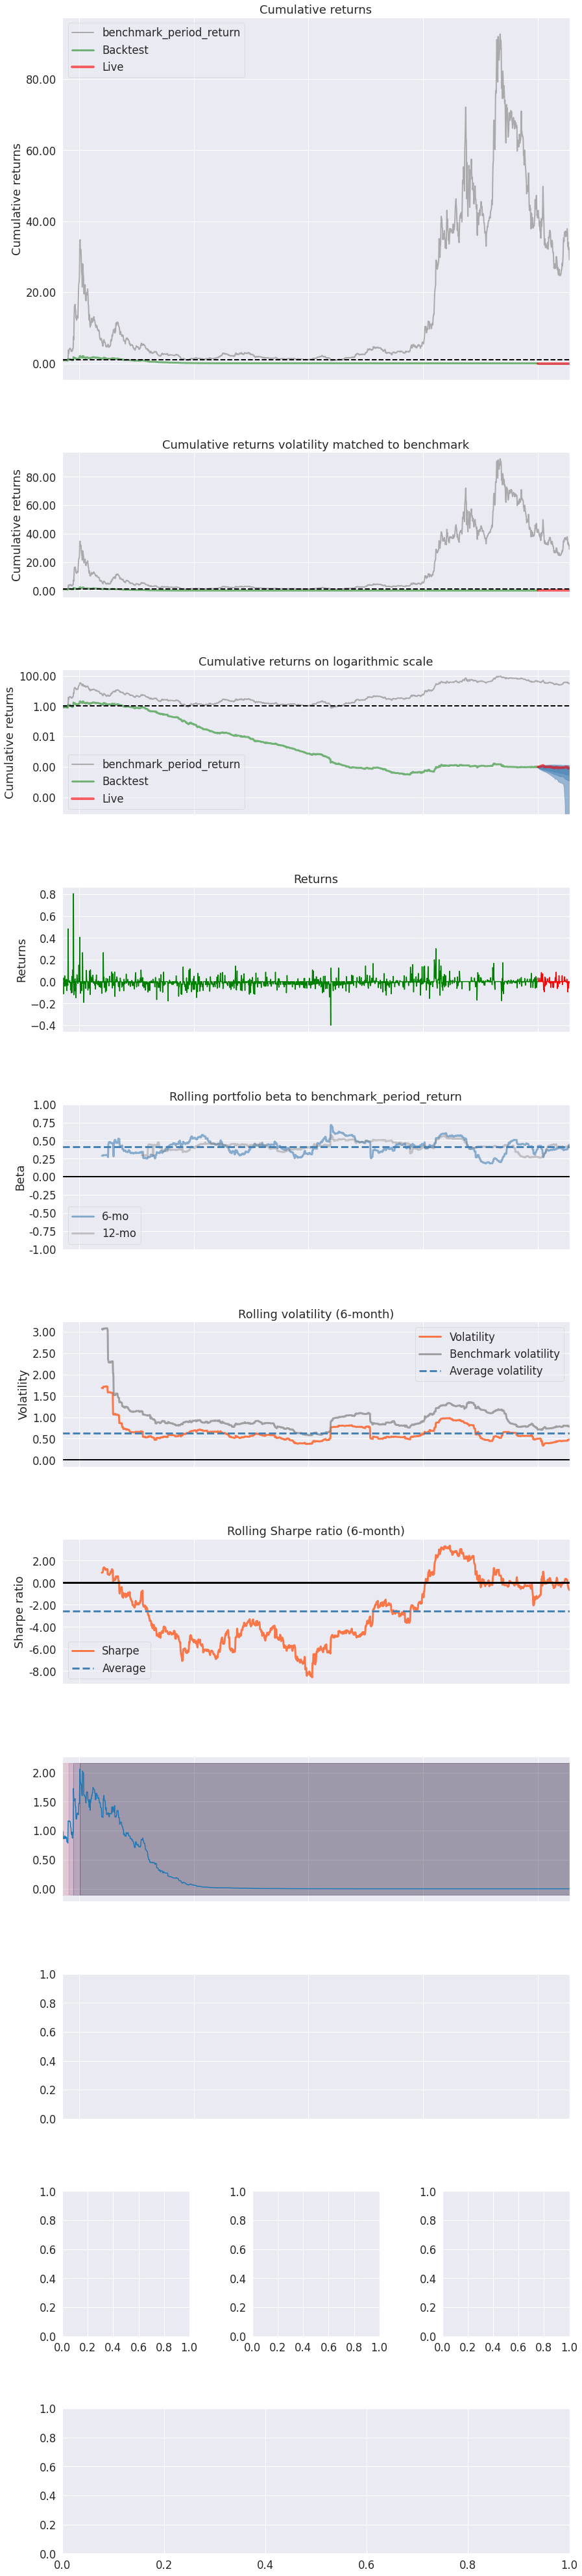

In [9]:
# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns, live_start_date='2022-01-01')

The strategy is not good with just sentiment data alone (and no other strategy), as expected. However, these alternative and quantitative NFT data we will be using could be more effective as features in a regression model aimed to predict returns.

## OLS / Regression + Simulated Sentiment Feature

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 2021-1-28 start
data_path = r"../data/instruments_modified"
instrument_symbols = [fn.split(".")[0] for fn in os.listdir(data_path)]

# Create hierarchical dataframe for universe of instruments?
pd.concat([pd.read_csv(os.path.join(data_path,file)) for file in os.listdir(data_path)], keys=instrument_symbols).swaplevel()

,,Date,Open,High,Low,Close,Volume,Market Cap
0,ADA,2017-10-02,0.024969,0.030088,0.019969,0.025808,8.310030e+07,5.672757e+08
1,ADA,2017-10-03,0.025671,0.027172,0.020575,0.020827,2.971484e+07,6.786349e+08
2,ADA,2017-10-04,0.020828,0.022962,0.020828,0.021973,1.243013e+07,5.695444e+08
3,ADA,2017-10-05,0.022035,0.022245,0.020839,0.021512,7.055960e+06,5.548686e+08
4,ADA,2017-10-06,0.021286,0.021576,0.018071,0.018481,6.207887e+06,5.219246e+08
...,...,...,...,...,...,...,...,...
1654,TFUEL,2022-04-13,0.164733,0.172376,0.163245,0.169795,2.146501e+07,8.879270e+08
1655,TFUEL,2022-04-14,0.169287,0.170751,0.160710,0.163625,2.503801e+07,8.824291e+08
1656,TFUEL,2022-04-15,0.163616,0.167434,0.163308,0.167315,2.003002e+07,8.769784e+08
1657,TFUEL,2022-04-16,0.167315,0.167884,0.162870,0.165885,1.721647e+07,8.795143e+08
